# Система предупреждения аварий на каршеринге 

В данном проекте,нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

## Подключаемся к базе. Загружаем таблицы sql

In [4]:
import pandas as pd
import datetime
import random
import numpy as np
import optuna


from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder 

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV

from sqlalchemy import create_engine
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


from skorch import NeuralNetClassifier
from torch import optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import skorch


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")


Импортируем нужные библиотеки

In [5]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [6]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [7]:
# %%time
# query_1 = '''
# SELECT *
# FROM vehicles

# '''
# sample_df_1 = pd.read_sql_query(query_1, con=engine) 
# sample_df_1

In [8]:
# %%time
# query_2 = '''
# SELECT *
# FROM collisions

# '''
# sample_df_2 = pd.read_sql_query(query_2, con=engine) 
# sample_df_2

In [9]:
# %%time
# query_3 = '''
# SELECT *
# FROM parties

# '''
# sample_df_3 = pd.read_sql_query(query_3, con=engine) 
# sample_df_3

- Все ли таблицы имеют набор данных;

        Да, все таблицы имеют набор данных
- Соответствует ли количество таблиц условию задачи;

        Да, все таблицы соответствуют условию задачи, но не все столбцы правильно подписаны как на ER - диаграмме. 
- Имеется ли общий ключ для связи таблиц.

        Да, имеется.

##  Проводим статистический анализ факторов ДТП

In [10]:
%%time
query_4 = '''
SELECT CAST(month AS int),
       user_count
FROM (SELECT EXTRACT(MONTH FROM collision_date) as month,
             COUNT(case_id) OVER (PARTITION BY EXTRACT(MONTH FROM collision_date)) AS user_count
      FROM collisions) AS tab_1
GROUP BY month, user_count
ORDER BY month

'''
sample_df_4 = pd.read_sql_query(query_4, con=engine) 
sample_df_4

Wall time: 3.32 s


,month,user_count
0,1,132044
1,2,128858
2,3,139581
3,4,130180
4,5,130316
5,6,102594
6,7,102227
7,8,104089
8,9,105159
9,10,112237


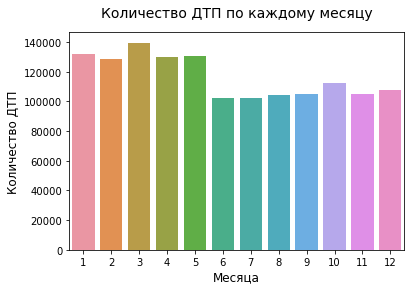

In [11]:
ax = sns.barplot(x="month", y="user_count", data=sample_df_4)
ax.set_title('Количество ДТП по каждому месяцу', fontsize=14, pad = 15)
ax.set_xlabel('Месяца', fontsize=12)
ax.set_ylabel('Количество ДТП', fontsize=12);

Построили график количества аварий в зависимости от месяца. Можно сделать вывод, что с января по май, риск ДТП намного выше, чем в оставшиеся месяца. 

## Создаем модель для оценки водительского риска

In [12]:
%%time
query_01 = '''

SELECT *
FROM vehicles AS v
INNER JOIN collisions AS c ON v.case_id = c.case_id
INNER JOIN parties AS p ON v.case_id = p.case_id
WHERE p.party_type = 'car' 
  AND EXTRACT(YEAR FROM c.collision_date) = 2012
  AND c.collision_damage != 'scratch'
 
'''
sample_df_01 = pd.read_sql_query(query_01, con=engine) 
sample_df_01.head(2)

Wall time: 20.8 s


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,case_id,county_city_location,county_location,distance,...,collision_time,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,1346998,5475395,1,sedan,manual,4.0,5475395,3018,orange,200.0,...,19:20:00,2444623,5475395,1,car,0,30.0,had not been drinking,None,0.0
1,1325945,5454272,2,sedan,manual,0.0,5454272,3010,orange,36.0,...,11:07:00,2405442,5454272,1,car,1,19.0,had not been drinking,None,0.0


In [13]:
sample_df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           118411 non-null  int64  
 1   case_id                      118411 non-null  object 
 2   party_number                 118411 non-null  int64  
 3   vehicle_type                 118411 non-null  object 
 4   vehicle_transmission         116545 non-null  object 
 5   vehicle_age                  115046 non-null  float64
 6   case_id                      118411 non-null  object 
 7   county_city_location         118411 non-null  object 
 8   county_location              118411 non-null  object 
 9   distance                     118411 non-null  float64
 10  direction                    89466 non-null   object 
 11  intersection                 118043 non-null  float64
 12  weather_1                    118022 non-null  object 
 13 

В Data Frame 118411 строк, 35 столбцов из них 5 - float64, 6 - int64 и 24 - object. В нашем Data Frame присутствуют значения NaN.

In [14]:
def graf(df, index, columns, values, aggfunc, set_title, xlabel, ylabel, labelrotat):
    df.pivot_table(index=index, 
                   columns=columns, 
                   values=values, 
                   aggfunc=aggfunc).plot(kind='bar', 
                                         figsize=(12, 4)).set_title(set_title, 
                                                                    fontsize=14, 
                                                                    y= 1.05)

    plt.xlabel(xlabel, fontsize=12, labelpad=10)
    plt.ylabel(ylabel, fontsize=12, labelpad=10)
    
    ax = plt.subplot()
    ax.tick_params(axis='x', labelrotation=labelrotat)
    
    plt.legend(fontsize=14, 
               shadow=True, 
               framealpha=1, 
               edgecolor='r',
               title='Серьёзность происшествия',
               loc='center', 
               bbox_to_anchor=(1.20, 0.50));

Функция для построения графиков

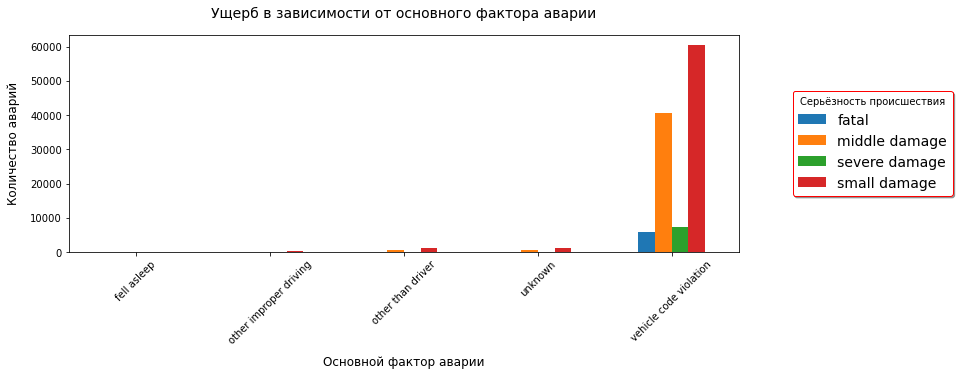

In [15]:
graf(sample_df_01,
     'primary_collision_factor',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Основной фактор аварии',
     'Количество аварий',
      45)


Из графика можно сделать вывод, что основной фактор аварии это vehicle_code_violation причем по всем вида серьёзности проишествия.

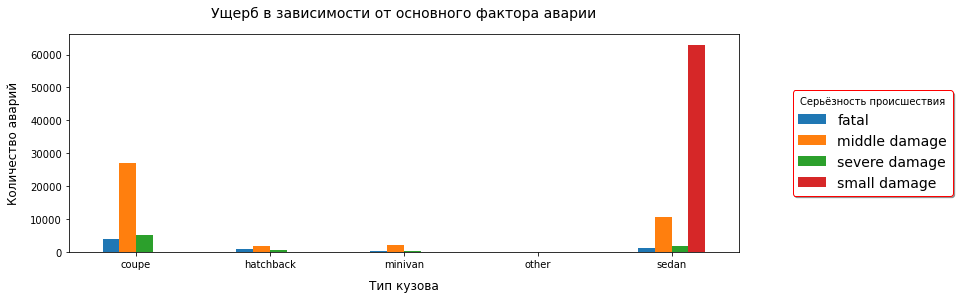

In [16]:
graf(sample_df_01,
     'vehicle_type',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Тип кузова',
     'Количество аварий',
      0)

Из графика можно сделать вывод, что тип кузова sedan и coupe лидируют по количеству ДТП. sedan по small damage, а coupe по midldle damage, вероятно машин этого класса намного больше чем других машин.

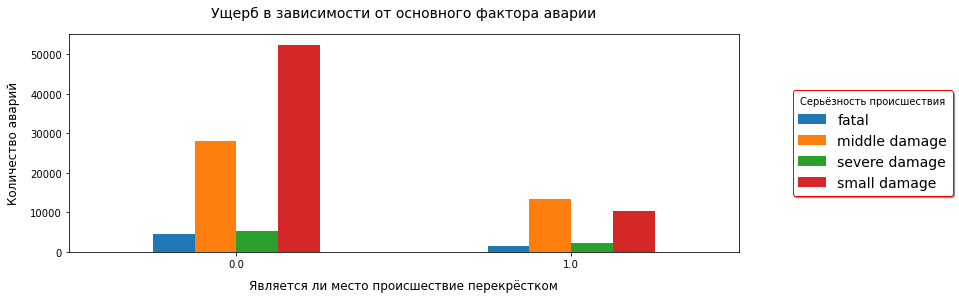

In [17]:
graf(sample_df_01,
     'intersection',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Является ли место происшествие перекрёстком',
     'Количество аварий',
      0)

Если брать из расчета, что 1 - это перекресток, а 0 - не перекресток, то по всем случаям кол-во аварий больше всего вне перекрестка.

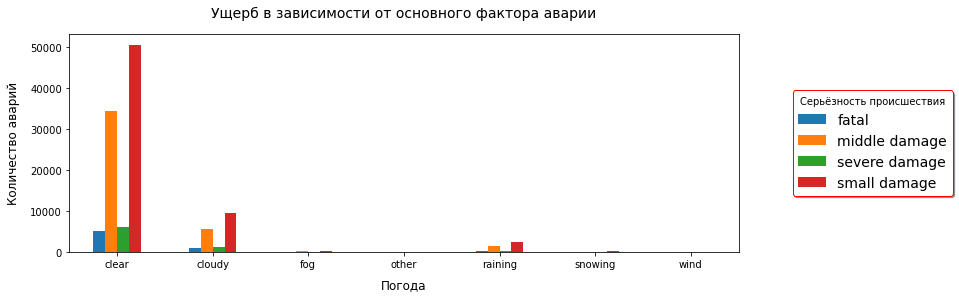

In [18]:
graf(sample_df_01,
     'weather_1',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Погода',
     'Количество аварий',
      0)

Практически все аварии случаются в dear погоду

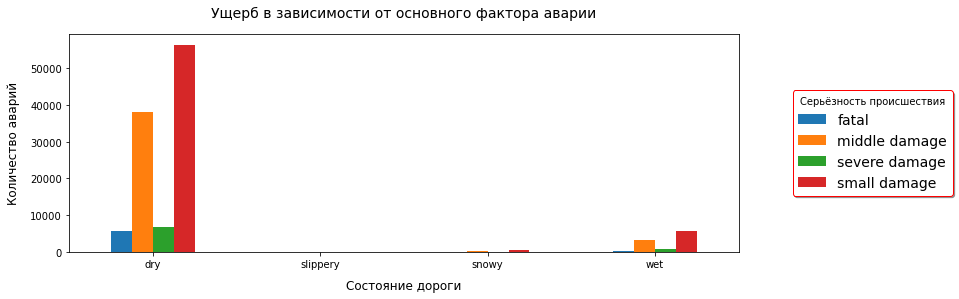

In [19]:
graf(sample_df_01,
     'road_surface',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Состояние дороги',
     'Количество аварий',
      0)

Почти все аварии проиходят на сухой дороге, возможно это связано с редким выпадением осадков, в виде дождя, снега и т д.

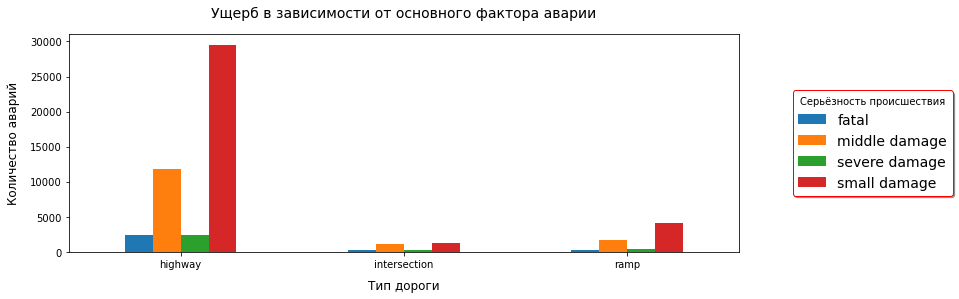

In [20]:
graf(sample_df_01,
     'location_type',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Тип дороги',
     'Количество аварий',
      0)

Опять, большинство аварий происходит на дороге Highway (Шоссе), что и следовало ожидать.

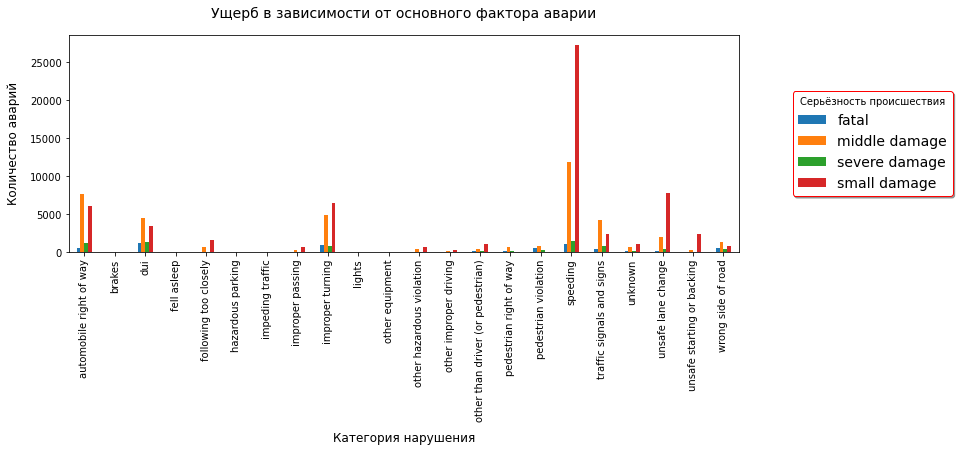

In [21]:
graf(sample_df_01,
     'pcf_violation_category',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Категория нарушения',
     'Количество аварий',
      90)

1 место в категории нарушения, естественно скорость, 2 место : Automobile Right of Way (Автомобильное право проезда), dui, Improper Turning (Неправильный поворот), Traffic Signals and Signs (Дорожные сигналы и знаки) и Unsafe Lane Change (Небезопасная смена полосы движения), осталые категории нарушения примерно в одинаковом кол-ве и и х не так много.


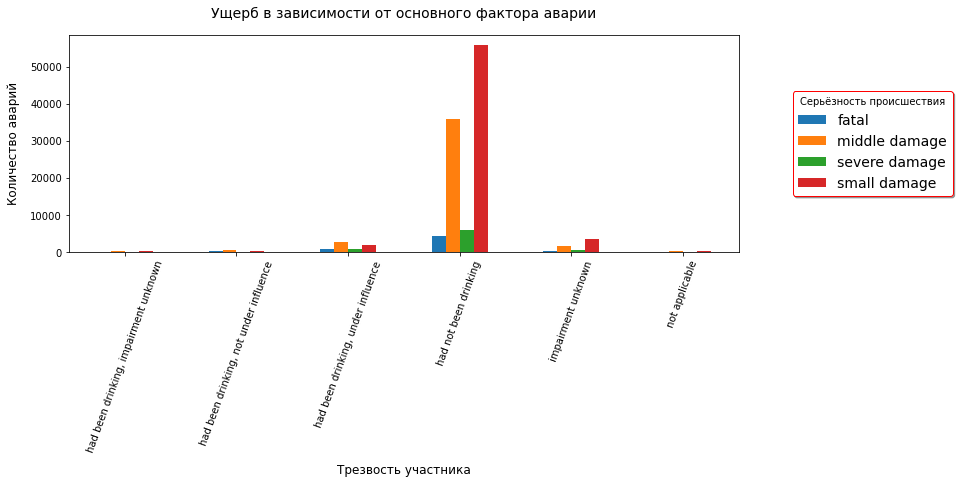

In [22]:
graf(sample_df_01,
     'party_sobriety',
     'collision_damage',
     'at_fault',
     'count',
     'Ущерб в зависимости от основного фактора аварии',
     'Трезвость участника',
     'Количество аварий',
      70)

Большинство аварий Had Not Been Drinking (Не пил), то так же есть небольшое кол-во Had Been Drinking, Under Influence (Был пьян, под влиянием) и  Impairment Unknown (Неизвестно ухудшение) примерно в равном кол-ве аварий.

In [23]:
%%time
query = '''
WITH
col AS (SELECT *
        FROM collisions
        WHERE EXTRACT(YEAR FROM collision_date) = 2012
          AND collision_damage != 'scratch'),

par AS (SELECT *
        FROM parties
        WHERE party_type = 'car')
            

SELECT v.vehicle_type,
       v.vehicle_age,
       col.county_city_location,
       col.county_location, 
       col.distance, 
       col.intersection,
       col.weather_1, 
       col.location_type, 
       col.collision_damage,
       col.road_surface, 
       col.road_condition_1,
       col.lighting, 
       col.control_device, 
       col.collision_date, 
       col.collision_time,
       col.primary_collision_factor, 
       par.at_fault, 
       par.cellphone_in_use,
       col.pcf_violation_category,
       col.type_of_collision,
       par.insurance_premium,
       par.party_sobriety,
       v.vehicle_transmission
       
     
FROM vehicles AS v
INNER JOIN col ON v.case_id = col.case_id
INNER JOIN par ON v.case_id = par.case_id

'''
sample_df = pd.read_sql_query(query, con=engine) 

Wall time: 23.3 s


Сделали запрос к 3-м таблицам, объеденив их так, чтобы вошли все строки со всех таблиц, перед этим, создав временные таблицы с нужным фильтром.

Выбираем все столбцы кроме: 

    - Кол-во участников, - не имеет значения, всегда random значение
    - Категория нарушения, - не имеет значения для обучения
    - Тип аварии, - не имеет значения для обучения
    - Дополнительные участники ДТП, - не влияет на модель 
    - Номер участника происшествия, - не влияет на модель 
    - Состояние участника: физическое или с учётом принятых лекарств - т к мы НЕ знаем состояние на момент посадки в авто
    - Направление движения - тоже не имеет значение + в них много значений NaN
    - id - не имеет значения
    - case_id - не имеет значения
    - party_type - само сабой не нужен
    
    
Остальные признаки влияют на вероятность ДТП.

In [24]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   vehicle_type              118411 non-null  object 
 1   vehicle_age               115046 non-null  float64
 2   county_city_location      118411 non-null  object 
 3   county_location           118411 non-null  object 
 4   distance                  118411 non-null  float64
 5   intersection              118043 non-null  float64
 6   weather_1                 118022 non-null  object 
 7   location_type             55137 non-null   object 
 8   collision_damage          118411 non-null  object 
 9   road_surface              117645 non-null  object 
 10  road_condition_1          117843 non-null  object 
 11  lighting                  118080 non-null  object 
 12  control_device            117957 non-null  object 
 13  collision_date            118411 non-null  o

В наше Data Frame 118411 строк, 18 столбцов из них 4 - float64, 1 - int64 и 13 - object. В нашем Data Frame присутствуют значения NaN.

### Дубликаты в Data Frame

При выгрзке всех столбцов из SQL запроса, дубликатов не обнаружено.

### Распределение данных в Data Frame

In [25]:
df  = sample_df.copy()

In [26]:
df.describe()

,vehicle_age,distance,intersection,at_fault,cellphone_in_use,insurance_premium
count,115046.000000,1.184110e+05,118043.000000,118411.000000,107507.000000,113289.000000
mean,4.908263,7.320663e+02,0.234711,0.469686,0.021320,38.624686
std,3.266265,6.902704e+03,0.423820,0.499082,0.144448,16.355164
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000e+00,0.000000,0.000000,0.000000,25.000000
50%,4.000000,1.180000e+02,0.000000,0.000000,0.000000,36.000000
75%,7.000000,5.280000e+02,0.000000,1.000000,0.000000,50.000000
max,161.000000,1.584000e+06,1.000000,1.000000,1.000000,105.000000


Странное значение в возрасте машины. Посмотрим ниже

### Удаление строк в Data Frame

In [27]:
df.vehicle_age.value_counts(ascending=True)

19.0         1
161.0        4
17.0         6
16.0        20
15.0        81
14.0       607
13.0      1195
12.0      1889
11.0      3020
10.0      4305
1.0       5701
9.0       6106
0.0       6741
8.0       7672
7.0       8344
6.0       8514
5.0      11781
2.0      12818
4.0      14618
3.0      21623
Name: vehicle_age, dtype: int64

Одной из машин 161 год. Посмотрим на нее.

In [28]:
df[df['vehicle_age'] == 161.0]

,vehicle_type,vehicle_age,county_city_location,county_location,distance,intersection,weather_1,location_type,collision_damage,road_surface,...,collision_date,collision_time,primary_collision_factor,at_fault,cellphone_in_use,pcf_violation_category,type_of_collision,insurance_premium,party_sobriety,vehicle_transmission
40805,sedan,161.0,1942,los angeles,449.0,0.0,clear,None,fatal,dry,...,2012-06-20,11:45:00,vehicle code violation,1,0.0,speeding,head-on,18.0,had not been drinking,manual
40807,sedan,161.0,1942,los angeles,449.0,0.0,clear,None,fatal,dry,...,2012-06-20,11:45:00,vehicle code violation,0,0.0,speeding,head-on,53.0,had not been drinking,manual
115136,sedan,161.0,1942,los angeles,0.0,1.0,clear,ramp,fatal,dry,...,2012-12-05,05:55:00,vehicle code violation,1,0.0,automobile right of way,head-on,42.0,had not been drinking,manual
115138,sedan,161.0,1942,los angeles,0.0,1.0,clear,ramp,fatal,dry,...,2012-12-05,05:55:00,vehicle code violation,0,0.0,automobile right of way,head-on,22.0,had not been drinking,manual


В этих строках есть дубликаты, да и год машины очень большой, удалим эти строки. Т к они ни на что не повлияют.

In [29]:
df = df[df['vehicle_age'] != 161.0]

In [30]:
df[df['vehicle_age'] == 161.0]

,vehicle_type,vehicle_age,county_city_location,county_location,distance,intersection,weather_1,location_type,collision_damage,road_surface,...,collision_date,collision_time,primary_collision_factor,at_fault,cellphone_in_use,pcf_violation_category,type_of_collision,insurance_premium,party_sobriety,vehicle_transmission


Удалили строки и проверили результат.

In [31]:
df = df[df['distance'] <= 20000]

В столбце с дистанцией, есть аномальных значений т к расстояние указано в метрах (Расстояние от главной дороги (метры)). Ограничимся дестанцией в 20 км.

In [32]:
df[df['distance'] > 20000]

,vehicle_type,vehicle_age,county_city_location,county_location,distance,intersection,weather_1,location_type,collision_damage,road_surface,...,collision_date,collision_time,primary_collision_factor,at_fault,cellphone_in_use,pcf_violation_category,type_of_collision,insurance_premium,party_sobriety,vehicle_transmission


Проверяем удаление

### Заполняем NaN в Data Frame

In [33]:
df.isna().sum()

vehicle_type                    0
vehicle_age                  3365
county_city_location            0
county_location                 0
distance                        0
intersection                  367
weather_1                     389
location_type               63181
collision_damage                0
road_surface                  763
road_condition_1              568
lighting                      331
control_device                454
collision_date                  0
collision_time                126
primary_collision_factor      263
at_fault                        0
cellphone_in_use            10902
pcf_violation_category       1724
type_of_collision             640
insurance_premium            5119
party_sobriety               1723
vehicle_transmission         1865
dtype: int64

Смотрим на кол-во NaN в столбцах

In [34]:
df.location_type.value_counts()

highway         45828
ramp             6254
intersection     2866
Name: location_type, dtype: int64

In [35]:
df['location_type'] = df['location_type'].fillna('unknown')

Заполним значением "unknown" столбец location_type

In [36]:
df.cellphone_in_use.value_counts()

0.0    104939
1.0      2288
Name: cellphone_in_use, dtype: int64

In [37]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0.0)

Заполнили Nan в столбце cellphone_in_use самым частым значением, т е 0.0

In [38]:
df.isna().sum()

vehicle_type                   0
vehicle_age                 3365
county_city_location           0
county_location                0
distance                       0
intersection                 367
weather_1                    389
location_type                  0
collision_damage               0
road_surface                 763
road_condition_1             568
lighting                     331
control_device               454
collision_date                 0
collision_time               126
primary_collision_factor     263
at_fault                       0
cellphone_in_use               0
pcf_violation_category      1724
type_of_collision            640
insurance_premium           5119
party_sobriety              1723
vehicle_transmission        1865
dtype: int64

### Удаляем строки с оставшиемися NaN в Data Frame

In [39]:
df = df.dropna(subset=['vehicle_age',
                       'intersection',
                       'weather_1',
                       'road_surface',
                       'road_condition_1',
                       'lighting',
                       'control_device',
                       'collision_time',
                       'primary_collision_factor',
                       'pcf_violation_category',
                       'type_of_collision',
                       'insurance_premium',
                       'party_sobriety',
                       'vehicle_transmission'
                       ])

In [40]:
df.isna().sum()

vehicle_type                0
vehicle_age                 0
county_city_location        0
county_location             0
distance                    0
intersection                0
weather_1                   0
location_type               0
collision_damage            0
road_surface                0
road_condition_1            0
lighting                    0
control_device              0
collision_date              0
collision_time              0
primary_collision_factor    0
at_fault                    0
cellphone_in_use            0
pcf_violation_category      0
type_of_collision           0
insurance_premium           0
party_sobriety              0
vehicle_transmission        0
dtype: int64

Удалил строки с NaN значениями, т к их очень мало и не будем вносить лишние шумы в данные. А в категориальных признаках, нет очень сильного перевеса к одному типу значения.

### Замена типа данных в Data Frame

In [41]:
df['vehicle_age'] = df['vehicle_age'].astype('int')
df['intersection'] = df['intersection'].astype('int')
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int')

Меняем тип данных с float на int в столбцах vehicle_age, intersection, cellphone_in_use методом astype

In [42]:
%%time
df['collision_date'] = pd.to_datetime(df['collision_date'])            # Преобразовываем в тип datetime
df['collision_date'] = pd.DatetimeIndex(df['collision_date']).month    # Оставляем только месяц

Wall time: 66 ms


Из даты оставили только месяц ДТП

In [43]:
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')   # Преобразовываем в datetime 
df['collision_time'] = df['collision_time'].apply(lambda x: x.hour)              # Оставляем только час 

Из времени оставили только час ДТП

###  Разбиение признаков

In [44]:
df['at_fault'].value_counts()

0    56212
1    47171
Name: at_fault, dtype: int64

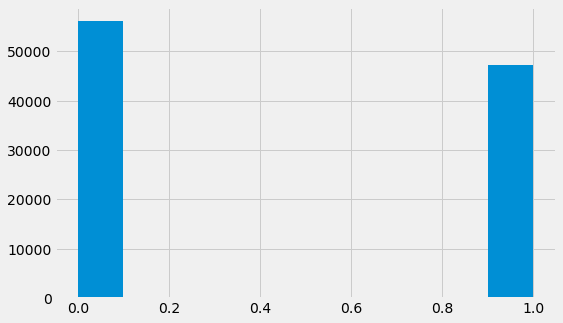

In [45]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8,5]

plt.hist(df['at_fault'])
plt.show()

Дисбаланс классов приемлемый

In [46]:
target_df = df['at_fault']
features_df = df.drop('at_fault', axis=1)

features_train_df, features_test_df, target_train_df, target_test_df = train_test_split(
    features_df.copy(), target_df.copy(), test_size=0.25, shuffle=True, random_state=69)

Разбили Data Frame в соотношении 75 / 25.

In [47]:
features_train_df.shape

(77537, 22)

In [48]:
features_test_df.shape

(25846, 22)

In [49]:
target_train_df.shape

(77537,)

In [50]:
target_test_df.shape

(25846,)

Проверили размер выборок 

###  Кодирование категориальных признаков

In [51]:
object_colum_features_train_df = features_train_df.select_dtypes(include=['object']).columns.tolist().copy()
object_colum_features_train_df 

['vehicle_type',
 'county_city_location',
 'county_location',
 'weather_1',
 'location_type',
 'collision_damage',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'primary_collision_factor',
 'pcf_violation_category',
 'type_of_collision',
 'party_sobriety',
 'vehicle_transmission']

In [52]:
object_colum_features_test_df = features_test_df.select_dtypes(include=['object']).columns.tolist().copy()
object_colum_features_test_df 

['vehicle_type',
 'county_city_location',
 'county_location',
 'weather_1',
 'location_type',
 'collision_damage',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'primary_collision_factor',
 'pcf_violation_category',
 'type_of_collision',
 'party_sobriety',
 'vehicle_transmission']

Выбираем только категориальные столбцы и делаем список столбцов

**Кодирование с помощью OrdinalEncoder**

In [54]:
features_train_df.head(2)

,vehicle_type,vehicle_age,county_city_location,county_location,distance,intersection,weather_1,location_type,collision_damage,road_surface,...,control_device,collision_date,collision_time,primary_collision_factor,cellphone_in_use,pcf_violation_category,type_of_collision,insurance_premium,party_sobriety,vehicle_transmission
59098,sedan,4,3801,san francisco,200.0,0,clear,highway,small damage,dry,...,none,1,22,vehicle code violation,0,speeding,rear end,28.0,"had been drinking, not under influence",auto
85171,sedan,6,1942,los angeles,84.0,0,clear,unknown,small damage,dry,...,none,5,7,vehicle code violation,0,improper passing,sideswipe,56.0,had not been drinking,auto


In [55]:
features_train_df_lgbmclassifier = features_train_df.copy()
features_test_df_lgbmclassifier = features_test_df.copy()

encoder = OrdinalEncoder()

features_train_df_lgbmclassifier[object_colum_features_train_df] = encoder.fit_transform(features_train_df_lgbmclassifier[object_colum_features_train_df])
features_test_df_lgbmclassifier[object_colum_features_test_df] = encoder.fit_transform(features_test_df_lgbmclassifier[object_colum_features_test_df])

features_test_df_lgbmclassifier.head(2)

,vehicle_type,vehicle_age,county_city_location,county_location,distance,intersection,weather_1,location_type,collision_damage,road_surface,...,control_device,collision_date,collision_time,primary_collision_factor,cellphone_in_use,pcf_violation_category,type_of_collision,insurance_premium,party_sobriety,vehicle_transmission
81213,0.0,13,251.0,30.0,0.0,1,0.0,1.0,1.0,0.0,...,1.0,5,13,4.0,0,0.0,0.0,38.0,3.0,1.0
81051,4.0,7,0.0,0.0,10.0,0,0.0,0.0,3.0,0.0,...,1.0,5,14,4.0,0,15.0,5.0,53.0,3.0,0.0


Кодировали категориальные признаки с помощью OrdinalEncoder для модели lgbmclassifier. Проверяем работу OrdinalEncoder

###  Построение CatBoostClassifier с использованием HalvingGridSearchCV и optuna

**Грубо посчитаем гиперпараметры HalvingGridSearchCV :**

In [56]:
%%time
param = {'learning_rate': [0.01, 0.2],
         'depth' : [5, 6, 7],
         'n_estimators' : [900, 1000, 1100]
        }

model_1 = CatBoostClassifier(loss_function = 'Logloss',                         
                             random_state = 69,
                             verbose = False)


search_1 = HalvingGridSearchCV(model_1, 
                                param,      
                                random_state=69, 
                                cv=3, 
                                n_jobs = -1, 
                                scoring = 'f1').fit(features_train_df, 
                                                    target_train_df,
                                                    cat_features=object_colum_features_train_df,
                                                    plot=False)
search_1.best_params_

Wall time: 17min 34s


{'depth': 5, 'learning_rate': 0.2, 'n_estimators': 1000}

In [57]:
search_1.best_score_

0.6333158265167987

**Более точные гиперпараметры посчитаем при помощи optuna :**

In [60]:
%%time
param = {
    'objective' : optuna.distributions.CategoricalDistribution(['Logloss']),
    'depth' : optuna.distributions.IntUniformDistribution(4, 7),
    'n_estimators' : optuna.distributions.IntUniformDistribution(900, 1100, 10),
    'learning_rate' : optuna.distributions.LogUniformDistribution(0.15, 0.25)
}
    
gbm_1 = CatBoostClassifier(verbose=False)
    
optuna_search_1 = optuna.integration.OptunaSearchCV(gbm_1, param, scoring = 'f1', n_trials=20, cv=3)
   
optuna_search_1.fit(features_train_df, target_train_df, cat_features=object_colum_features_train_df)

[I 2022-08-28 14:44:09,902] A new study created in memory with name: no-name-346d0c19-b8dc-4521-8035-5198410273d7
[I 2022-08-28 14:48:55,368] Trial 0 finished with value: 0.6361081028166639 and parameters: {'objective': 'Logloss', 'depth': 6, 'n_estimators': 1040, 'learning_rate': 0.15378345296291954}. Best is trial 0 with value: 0.6361081028166639.
[I 2022-08-28 14:52:07,849] Trial 1 finished with value: 0.6310586264517388 and parameters: {'objective': 'Logloss', 'depth': 4, 'n_estimators': 1050, 'learning_rate': 0.20206174586374204}. Best is trial 0 with value: 0.6361081028166639.
[I 2022-08-28 14:56:36,296] Trial 2 finished with value: 0.6376120513952289 and parameters: {'objective': 'Logloss', 'depth': 6, 'n_estimators': 970, 'learning_rate': 0.24265465689424418}. Best is trial 2 with value: 0.6376120513952289.
[I 2022-08-28 15:01:43,089] Trial 3 finished with value: 0.6394830750703496 and parameters: {'objective': 'Logloss', 'depth': 7, 'n_estimators': 940, 'learning_rate': 0.1620

Wall time: 1h 39min 14s


OptunaSearchCV(cv=3,
               estimator=<catboost.core.CatBoostClassifier object at 0x00000292C1D3FFA0>,
               n_trials=20,
               param_distributions={'depth': IntUniformDistribution(high=7, low=4, step=1),
                                    'learning_rate': LogUniformDistribution(high=0.25, low=0.15),
                                    'n_estimators': IntUniformDistribution(high=1100, low=900, step=10),
                                    'objective': CategoricalDistribution(choices=('Logloss',))},
               scoring='f1')

In [61]:
optuna_search_1.best_params_

{'objective': 'Logloss',
 'depth': 6,
 'n_estimators': 1030,
 'learning_rate': 0.22867775499110396}

Лучшие параметры

In [62]:
optuna_search_1.best_score_

0.6466887664498601

Лучшая метрика 

In [63]:
optuna_search_1.best_estimator_

Оптимальная модель

In [64]:
accuracy = f1_score(target_test_df, optuna_search_1.best_estimator_.predict(features_test_df))
accuracy

0.6713670191931062

Метрика f1 = 0.6713

In [65]:
model_1 = CatBoostClassifier(**optuna_search_1.best_params_,
                             loss_function = 'Logloss',
                             random_state = 69,
                             verbose = False)


model_1.fit(features_train_df, target_train_df, cat_features=object_colum_features_train_df)
accuracy_1 = f1_score(target_test_df, model_1.predict(features_test_df))
accuracy_1

0.6727086683233445

Метрика на тестовой выборке f1 = 0.6727, на обучающей выборке f1 = 0.6439

In [66]:
print(classification_report(target_test_df, model_1.predict(features_test_df)))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78     14140
           1       0.78      0.59      0.67     11706

    accuracy                           0.74     25846
   macro avg       0.75      0.73      0.73     25846
weighted avg       0.75      0.74      0.73     25846



Выводим матрицу ошибок

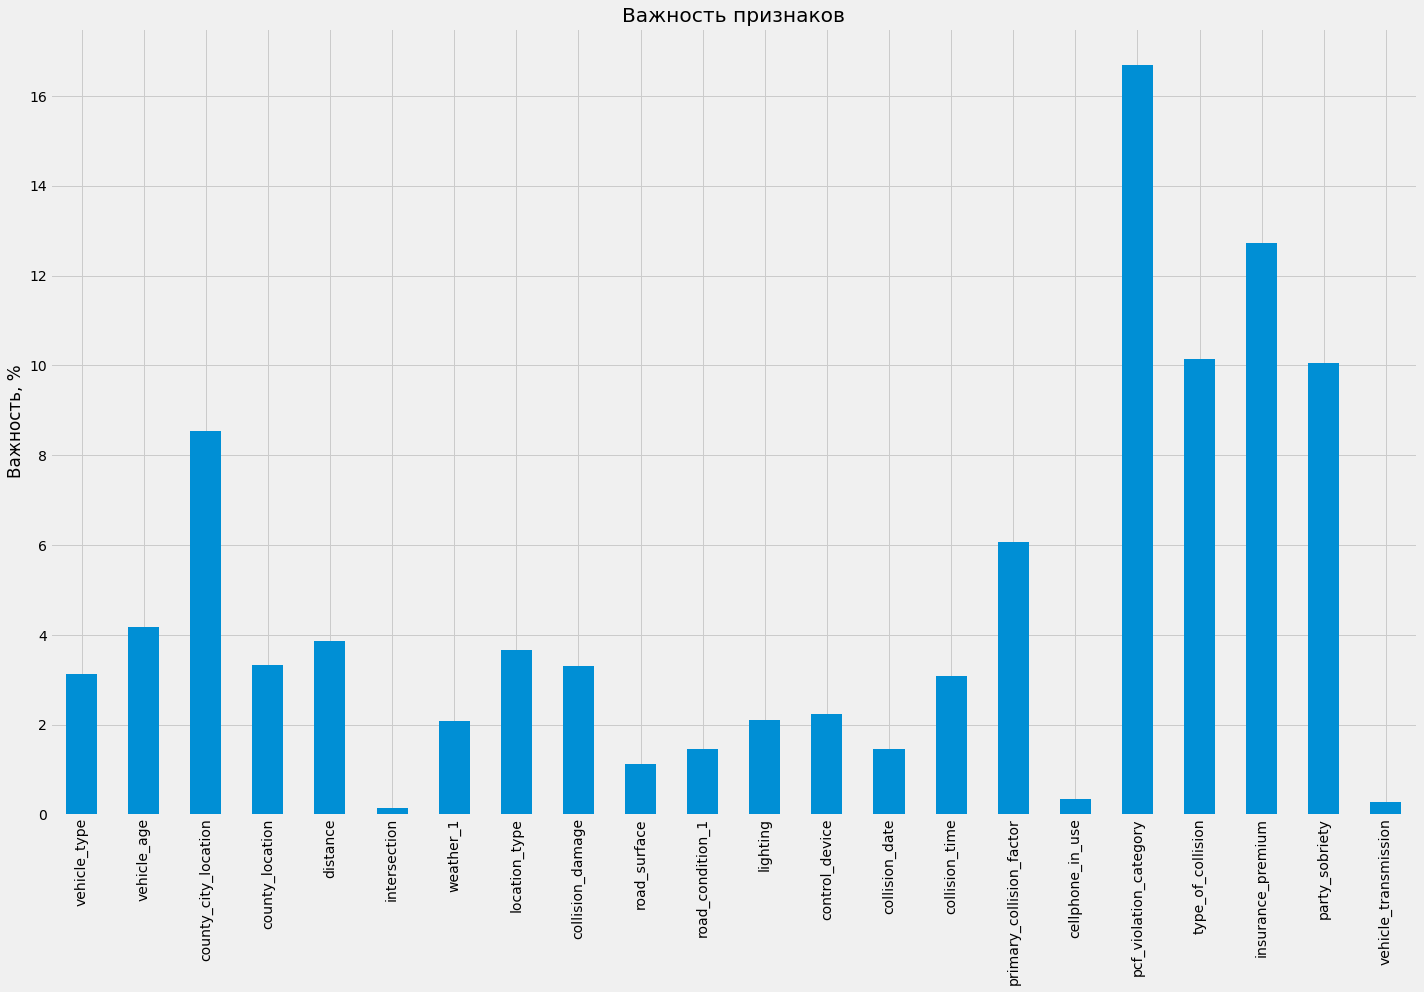

In [67]:
cat_imp = pd.Series(model_1.get_feature_importance(),
                         df.drop(['at_fault'], axis=1).columns)
fig, ax = plt.subplots(figsize=(20,14))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Есть признаки, которые очень сильно влияют на целевой признак

In [68]:
model_1.get_feature_importance(prettified=True).head(20)

,Feature Id,Importances
0,pcf_violation_category,16.679365
1,insurance_premium,12.735587
2,type_of_collision,10.145504
3,party_sobriety,10.054395
4,county_city_location,8.533340
5,primary_collision_factor,6.069110
6,vehicle_age,4.172926
7,distance,3.870033
8,location_type,3.656658
9,county_location,3.334355


Выводим важность признаков

###  Построение LGBMClassifier с использованием hyperopt

In [69]:
%%time
space = {'max_depth': hp.choice("max_depth", range(1, 10)),
         'n_estimators' : hp.choice('n_estimators', range(10, 500, 20)),
         'learning_rate': hp.uniform('learning_rate', 0.1, 0.3)
        }


def objective(space):
    model_2 = LGBMClassifier(max_depth = space['max_depth'],
                           n_estimators = space['n_estimators'],
                           learning_rate = space['learning_rate'],
                           first_metric_only = True, 
                           random_state = 69)
    
    f_1 = cross_val_score(model_2, 
                            features_train_df_lgbmclassifier, 
                            target_train_df, 
                            cv = 3, 
                            scoring = 'f1', 
                            n_jobs=-1)
     
    return {'loss': -f_1.mean(), 'status': STATUS_OK}


trials = Trials()

best_2 = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 200,
            trials = trials)

best_2

100%|█████████████████████████████████████████████| 200/200 [04:42<00:00,  1.41s/trial, best loss: -0.6180070369588413]
Wall time: 4min 42s


{'learning_rate': 0.2708736621649698, 'max_depth': 8, 'n_estimators': 24}

In [70]:
model_2 = LGBMClassifier(**best_2,
                         first_metric_only = True, 
                         random_state = 69)

model_2.fit(features_train_df_lgbmclassifier, target_train_df)
accuracy = f1_score(target_test_df, model_2.predict(features_test_df_lgbmclassifier))
accuracy

0.6014684581189751

Метрика на тестовой выборке f1 = 0.6014, на обучающей выборке f1 = 0.6180

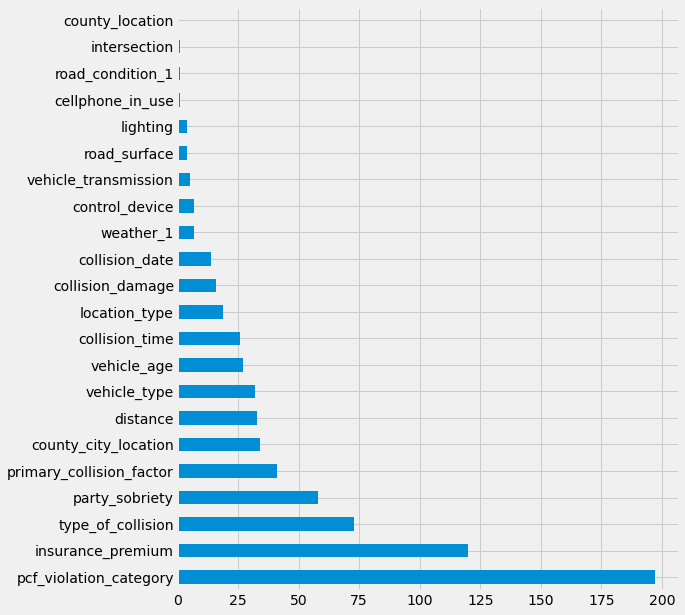

In [71]:
feat_imp = pd.Series(model_2.feature_importances_, index=features_train_df.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10));

Построили график важности признаков. Самый важный признак это категория нарушения

###  Построение RandomForestClassifier с использованием hyperopt

In [72]:
%%time
space = {'max_depth': hp.choice('max_depth', np.arange(1, 20, 2, dtype=int)),
         'n_estimators' : hp.choice('n_estimators', np.arange(10, 400, 20, dtype=int))
        }


def objective(space):
    model_3 = RandomForestClassifier(max_depth = space['max_depth'],
                                   n_estimators = space['n_estimators'])
    
    f_1 = cross_val_score(model_3, 
                            features_train_df_lgbmclassifier, 
                            target_train_df, 
                            cv = 3, 
                            scoring = 'f1', 
                            n_jobs=-1)
     
    return {'loss': -f_1.mean(), 'status': STATUS_OK}


trials = Trials()

best_3 = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials)

best_3

100%|█████████████████████████████████████████████| 100/100 [14:42<00:00,  8.82s/trial, best loss: -0.5972332463788351]
Wall time: 14min 42s


{'max_depth': 9, 'n_estimators': 13}

In [73]:
model_3 = RandomForestClassifier(**best_3)
model_3.fit(features_train_df_lgbmclassifier, target_train_df)
accuracy = f1_score(target_test_df, model_3.predict(features_test_df_lgbmclassifier))
accuracy

0.581383571356224

Метрика на тестовой выборке f1 = 0.5813, на обучающей выборке f1 = 0.5972

Метрику для обучения выбрали f1, она включает в себя precision и recall (точность и полноту). Высокий балл указывает на то, что модель хорошо разбирается с точки зрения обращения с задачей дисбаланса класса.

**Лучшая модель CatBoostClassifier с использованием HalvingGridSearchCV и optuna**

In [75]:
model_1 = CatBoostClassifier(**optuna_search_1.best_params_,
                             loss_function = 'Logloss',
                             random_state = 69,
                             verbose = False)


model_1.fit(features_train_df, target_train_df, cat_features=object_colum_features_train_df)
pred = model_1.predict(features_test_df)
accuracy_1 = f1_score(target_test_df, pred)
accuracy_1

0.6727086683233445

Метрика на тестовой выборке f1 = 0.6727

## Проводим анализ важности факторов ДТП

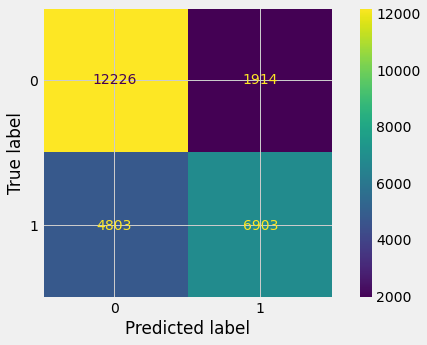

In [76]:
cm = confusion_matrix(target_test_df, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)

disp.plot()
plt.show()

Из матрицы ошибок можно сделать вывод, что наша модель очень плохо предсказывает класс 1 - ошибок 4803 и класс 0 - ошибок 1914. Именно поэтому у нас плохая метрика f1

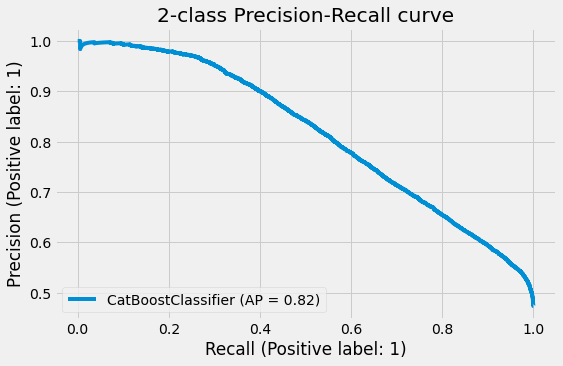

In [77]:
display = PrecisionRecallDisplay.from_estimator(
    model_1, features_test_df, target_test_df, name="CatBoostClassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

График Precision - Recall построенный по нашей лучшей модели

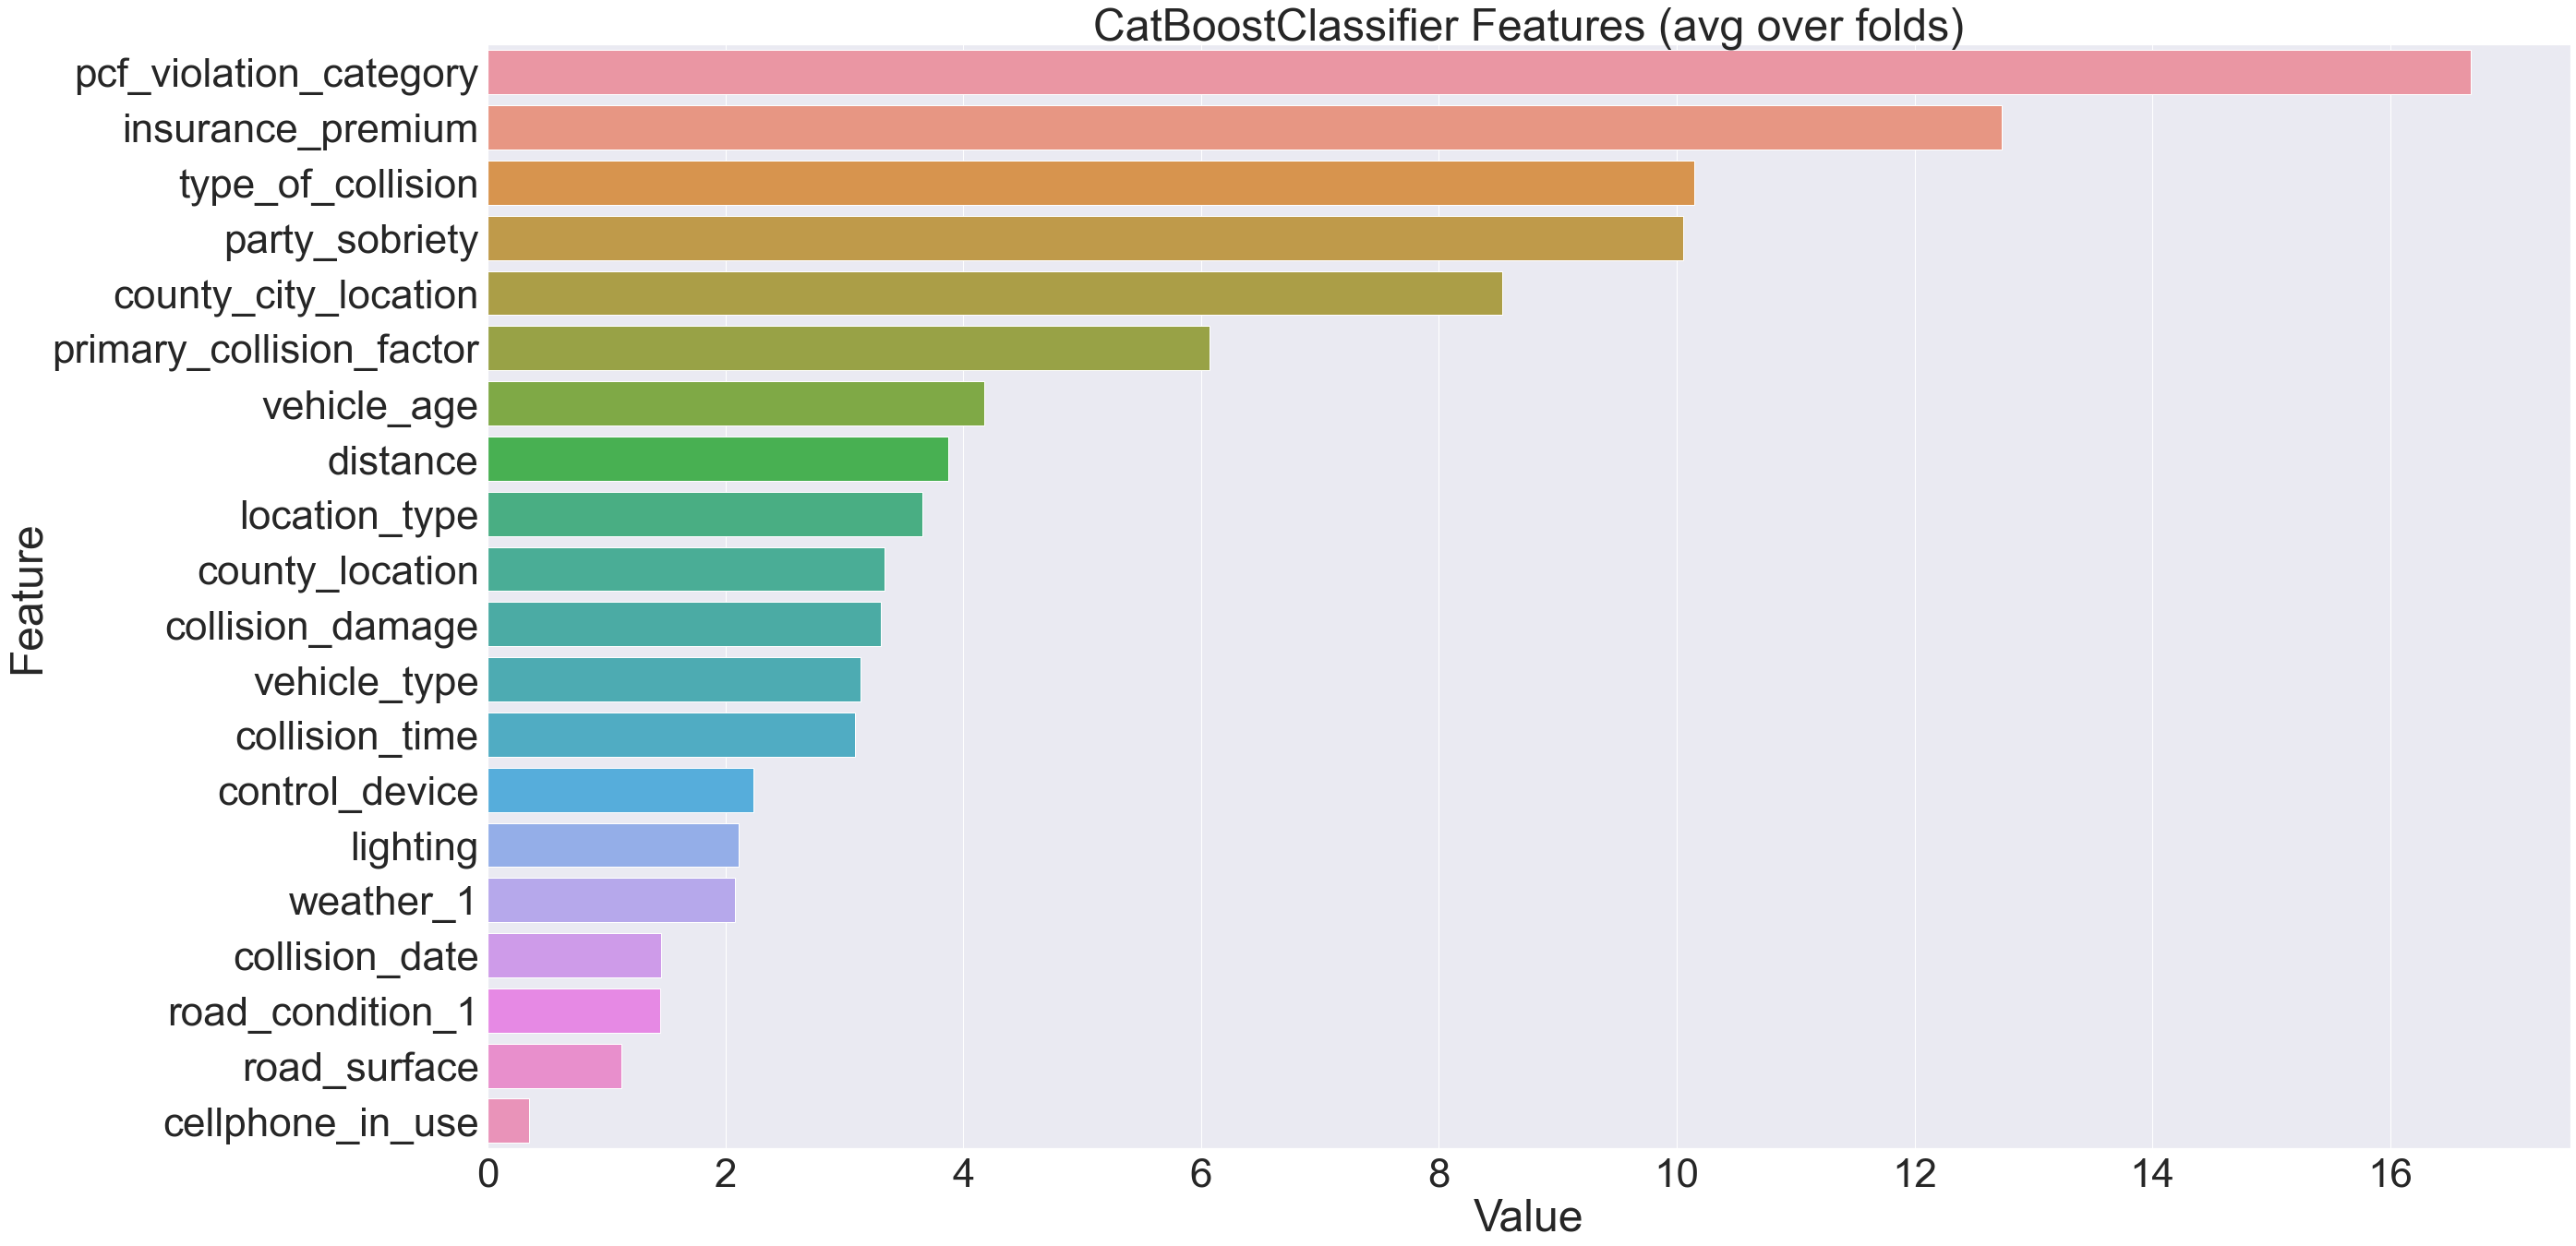

In [86]:
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model_1.feature_importances_,'Feature':features_train_df.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('CatBoostClassifier Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('CatBoostClassifier_importances-01.png')
    plt.show()
    
plotImp(model_2, features_train_df)    

Выведем важные признаки для модели model_1. На графике видно, что самый важный признак PCF_VIOLATION_CATEGORY

In [84]:
model_1.get_feature_importance(prettified=True).head(20)

,Feature Id,Importances
0,pcf_violation_category,16.679365
1,insurance_premium,12.735587
2,type_of_collision,10.145504
3,party_sobriety,10.054395
4,county_city_location,8.533340
5,primary_collision_factor,6.069110
6,vehicle_age,4.172926
7,distance,3.870033
8,location_type,3.656658
9,county_location,3.334355


pcf_violation_category - 16.67 % влияет на нашу модель, insurance_premium , type_of_collision, party_sobriety - принаки влияют примерно в одинаковой мере.

In [88]:
sample_df_01['pcf_violation_category'].value_counts(normalize=True).to_frame()

,pcf_violation_category
speeding,0.357609
automobile right of way,0.132424
improper turning,0.112927
dui,0.089805
unsafe lane change,0.088382
traffic signals and signs,0.066272
wrong side of road,0.028084
unsafe starting or backing,0.023790
following too closely,0.020602
unknown,0.017029


в 35,7% ДТП происходит по причине speeding (превышение скорости), остальные случаи, имеют гораздо меньшее влияние на аварию.

**Вывод**

Что можно сделать, чтобы было меньше таких аварий? Судя по нашим исследованиям, PCF_VIOLATION_CATEGORY - в котором  нарушение скорости имеет очень большое влияние на аварийность. Чтобы водители меньше превышали скорость, следует увеличить штрафы, возможно поставить какие-то ограничение в машину, например, по городу, чтобы машина не могла разогнаться быстрее положенной скорости (с учетом погрешности в каждом штате конечно же), на трассе тоже стоит ограничить скорость, возможно даже установить камеры превышения скорости. Опять же, мы не брали во внимание признак состояние водителя после дтп, т к нет возможности определить, в каком состоянии садится водитель за руль машины, к тому же в США есть допуски по наличию алкоголя в крови для управления ТС и они значительны. Поэтому, нет смысла ставить какие-то приборы в авто для контроля состояния алко - нарко в момент движения. Остается только одно, реально осуществимое решение - это пропагада культуры вождения, трезвого вождения и т д.

## Выводы

Наша лучшая модель, далеко не самая лучшая, т к у нас она очень сильно ошибается. В данном случае, нет возможности для создания адекватной модели для системы оценки риска при выдаче авто. Рекомендация тут только одна, смотреть на адекватность водителя и его состояние. Данных следует собирать как можно больше, например, качество резины на авто и ее производитель, более тщательно и точно собирать текущие данные, чтобы минимизировать предобработку, как минимум значений NaN. 